

## **Showcase: Non-linear regression with neural networks**
---
### **Authors**
Ryan Tuckman - rxt224@psu.edu (B.S. at Penn State University Park | Computer Science)

Sahil Kuwadia - szk6258@psu.edu (B.S. at Penn State University Park | Computer Science)

Rabah Abdul Khalek - khalek@jlab.org (Postdoc at JLab | Theory division)  

Alexei Prokudin - prokudin@psu.edu (Professor of Physics at Penn State Berks)

<a target="_blank" href="https://github.com/prokudin/PHYS496-Fall2024/tree/main/Tutorials/PHYS496_Fall_2024_(4)_PyTorch_Nonlinear_Regression_with_NN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### **Learning Goals**

This notebook will serve as an introduction to non-linear regression using neural networks. We will learn how to build and train neural networks with PyTorch, a powerful machine learning library.




---




## **Overview**

In this tutorial, we will be working with the [Gluon dataset](https://github.com/rabah-khalek/TF_tutorials/tree/master/PseudoData). A gluon is an elementary particle which gives rise to the strong force, which is the force responsible for binding together the protons and neutrons together in atomic nuclei.

The gluon is exchanged by other elementary particles in the proton and neutron called quarks. These quarks and gluons are more generally referred to as "partons".

Because of certain physical properties governing the partons, they cannot be observed by expermiments as free particles, and their distribution within the proton and neutron cannot be calculated analytically. Instead, their distribution must be inferred from data collected by high energy particle colliders like the Large Hadron Collider (LHC) at CERN.

A fast-moving proton can be described by the parton distribution function (PDF) $f(x)$, which gives the probability density of finding a parton of type $f$ (a specific quark type or gluon) carrying a fraction $x$ of the proton momentum.

The pseudodata used in this tutorial is generated from a gluon distribution function $g(x)$, which was determined in an analysis by the [NNPDF collaboration](http://nnpdf.mi.infn.it), aiming to extract the structure of the proton using contemporary machine learning methods. More specifically, NNPDF determines PDFs using neural networks as a minimally biased modeling tool, trained using Genetic Algorithms (and more recently stochastic gradient descent).

We will consider this pseudodata to be the *truth* that we're trying to *discover*. What we will actually fit is the *smeared truth*, where Gaussian noise is added to simulate more realistic data.

In [1]:
#@title Google colab mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the Gluon data set with Pandas**

There are four separate datasets each containing a total of 1000 gluon PDF predictions computed between $x=[x_{min},1]$; where:
- $x_{min} = 10^{-3}$ for `filename1`
- $x_{min} = 10^{-4}$ for `filename2`
- $x_{min} = 10^{-5}$ for `filename3`
- $x_{min} = 10^{-6}$ for `filename4`
  
Below we use `pandas` to import all datapoints from text files. We then use `sklearn` to split the data randomly into 800 points for training and 200 points for testing.

In [2]:
!git clone https://github.com/prokudin/PHYS496-Fall2024.git

Cloning into 'PHYS496-Fall2024'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 52 (delta 9), reused 42 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 35.35 MiB | 18.91 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [3]:
import pandas as pd

filename1='./PHYS496-Fall2024/Tutorials/data/gluon_NNPDF31_nlo_pch_as_0118_xmin1e-3.dat'
# Headers to skip
lines_to_skip = 5

# Defining the columns (cv = central value, sd = standard deviation)
columns=["x", "gluon_cv", "gluon_sd"]

# read data and create a dataframe
df = pd.read_csv(filename1,
                 sep="\s+",
                 skiprows=lines_to_skip,
                 usecols=[0,1,2],
                 names=columns)

Prepare the data by adding noise to the data.

In [4]:
import numpy as np

df_all = df.copy()

# Add noise to data
np.random.seed(42)
df_all['gluon_cv'] += np.random.normal(0, df_all['gluon_sd'])

This cell splits the data into two datasets 80% for training, 20% for testing. Please, find a way to do this directly in pytorch

In [5]:
# import a library from sklearn
from sklearn.model_selection import train_test_split

# Split data randomly into train and test sets using sklearn
df_train, df_test = train_test_split(df_all, test_size=0.2, random_state=42)

# Sort the split data by 'x' values
df_train = df_train.sort_values("x")
df_test = df_test.sort_values("x")

print("Data parsing is done!")
print(df_train)

Data parsing is done!
            x  gluon_cv  gluon_sd
0    0.001000  4.740935  0.523964
1    0.001007  4.406519  0.520743
2    0.001014  4.811565  0.517539
3    0.001021  5.257571  0.514349
4    0.001028  4.352346  0.511176
..        ...       ...       ...
993  0.952796 -0.003830  0.003990
994  0.959401 -0.004307  0.003423
996  0.972747  0.004232  0.002707
997  0.979490  0.000902  0.002179
999  0.993116  0.000255  0.000697

[800 rows x 3 columns]


Let us visualize these two datasets

In [6]:
import matplotlib.pyplot as plt

def createTrainTestPlots(train, test):
  """
  plots the data from the train and test sets.

  :param train: Required, dataframe with keys in ["x", "gluon_cv", "gluon_sd"].
  :param test: Required, dataframe with keys in ["x", "gluon_cv", "gluon_sd"].
  """
  fig, ax = plt.subplots(1,2,figsize=(10, 3))
  ax[0].axhline(0,color='k',linewidth=0.5)
  ax[0].errorbar(train['x'], train['x']*train['gluon_cv'], train['gluon_sd'], fmt = '.', color='b', alpha=0.5)
  ax[0].set_title("Train data")
  ax[0].set_xlabel("x")
  ax[0].set_ylabel("g(x)")
  ax[0].set_ylim(-0.05,0.4)
  ax[1].axhline(0,color='k',linewidth=0.5)
  ax[1].errorbar(test['x'], test['x']*test['gluon_cv'], test['gluon_sd'], fmt = '.', color='r', alpha=0.5)
  ax[1].set_title("Test data")
  ax[1].set_xlabel("x")
  ax[1].set_ylabel("g(x)")
  ax[1].set_ylim(-0.05,0.4)
  plt.show()

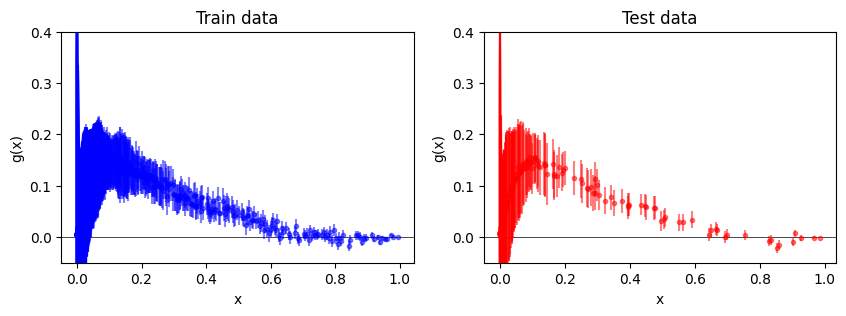

In [7]:
#createTrainTestPlots(df_train.dataset, df_test.dataset)
createTrainTestPlots(df_train, df_test)

## **Building a Neural Network using PyTorch**

The idea here is to fit the gluon distribution (which cannot be calculated analytically) using a neural network.

We will build the neural network of 1 input, 1 hidden layer, and 1 output.

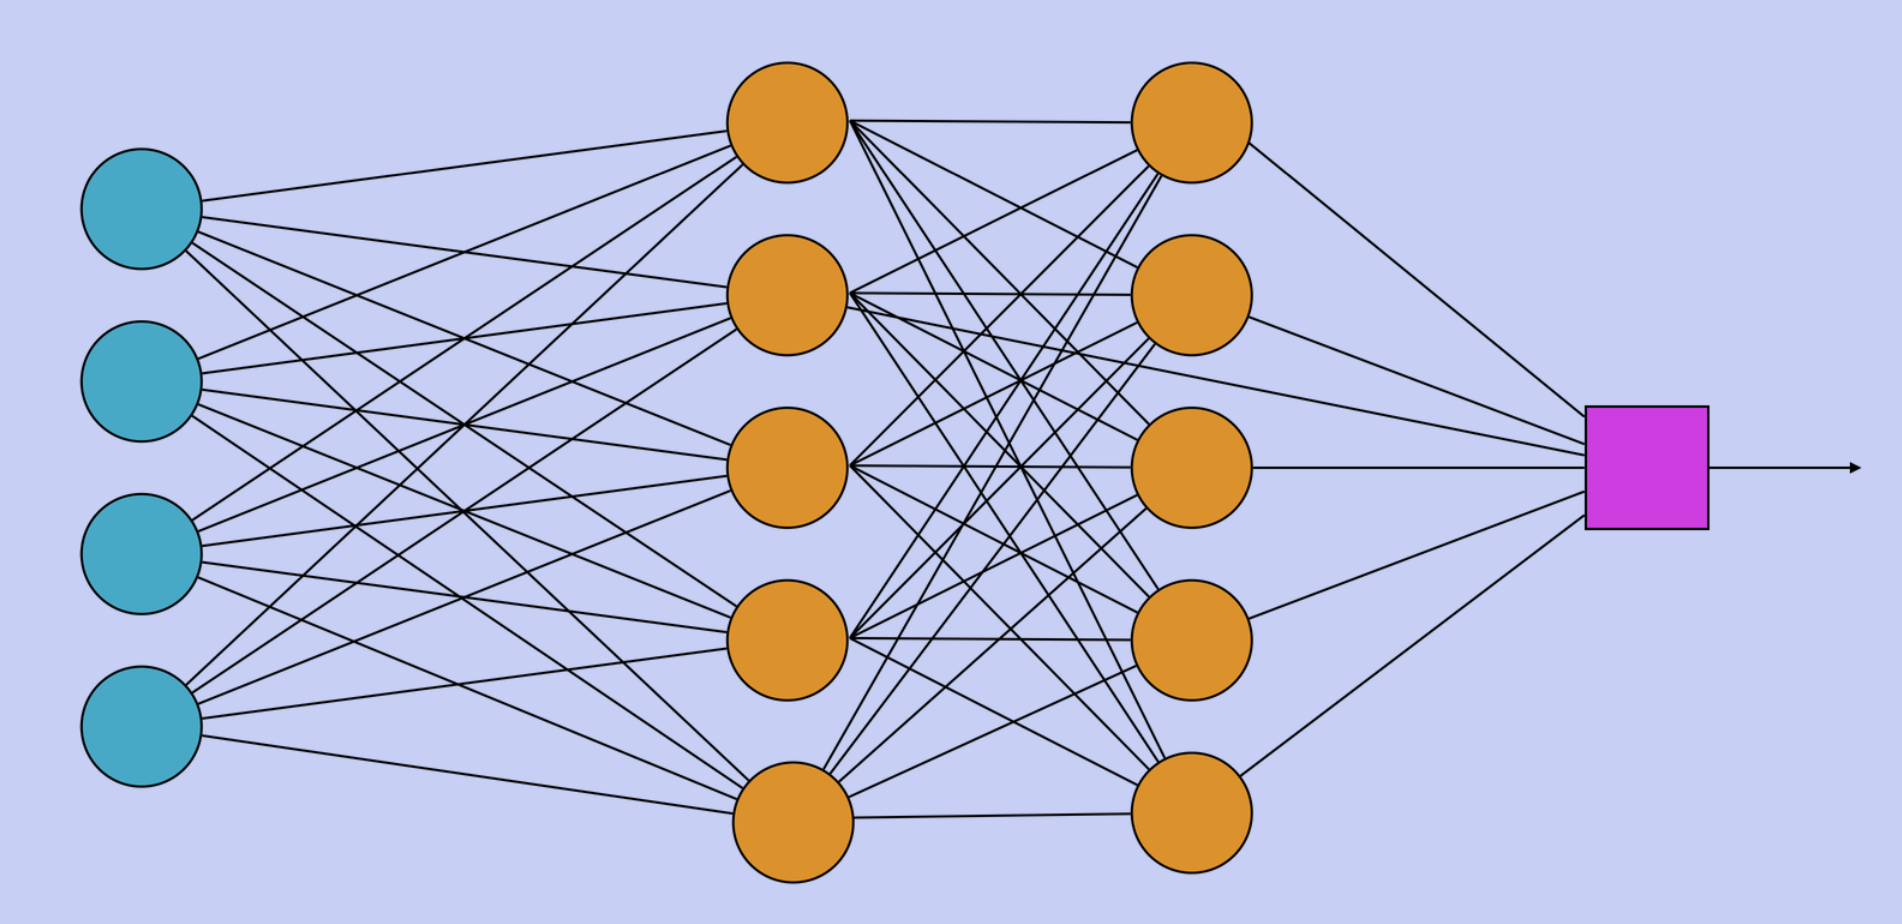

We consider a single layered neural network to be sufficient for our exercise here, but feel free to experiment with *deeper* architectures.

In [8]:
import torch
import torch.nn as nn

##################################################################
# Building NN from the PyTorch Application Programming Interface API (nn.Linear)
##################################################################

class Torch_Model(nn.Module):
    def __init__(self, n_features, n_neurons, n_outputs):
        super(Torch_Model, self).__init__()
        self.fc1 = nn.Linear(n_features, n_neurons)  # Hidden Layer 1
        self.sig1 = nn.Sigmoid() # Activation function
        self.fc2 = nn.Linear(n_neurons, n_outputs)  # Output Layer

    def forward(self, x):
        out = self.fc1(x)
        out = self.sig1(out)
        out = self.fc2(out)
        return out

This is how Sigmoid function looks like

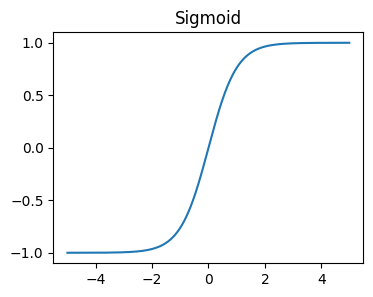

In [9]:
with torch.no_grad():
    x = torch.arange(-5,5,0.01)
    fig, ax = plt.subplots(1, 1, figsize=(4,3))

    y = torch.tanh(x)
    ax.plot(x.numpy(), y.numpy())
    ax.set_title("Sigmoid")
    ax.set_ylim(-1.1, 1.1)
    plt.subplots_adjust(wspace=0.4)
    plt.show()

## **Data modeling and fitting**

source: https://www-cdf.fnal.gov/physics/statistics/recommendations/modeling.html

The next few cells contain the bulk of the minimization routine.

Before we dive into it, let's review some important concepts applied:

### **Chi-square**

One of the most frequently occurring problems in high-energy physics is to compare an observed distribution with a prediction, for example from a simulation. Indeed, an analysis might be designed to extract some physical parameter from the simulation or prediction which best fits the data.  

For data points with Gaussian errors, the likelihood of a gaussian distribution is:

$$ L = \prod_i \frac{1}{\sqrt(2\pi\sigma^2)} e^{-\frac{(m_i - d_i)^2}{2\sigma_i^2}}$$

hence the following [MLE](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (maximum (log) likelihood estimation) gives:

$$ \chi^2 = \sum_i^N \left(\frac{m_i - d_i}{\sigma_i} \right)^2$$

where $m_i$ is the model evaluated at point $x_i$, $d_i$ is the data, and $\sigma_i$ is the uncertainty on the data at this point.

The chi-square expresses the deviation of the observed data from the fit, weighted inversely by the uncertainties in the individual points. The chi-square can be either used to test how well a particular model describes the data or, if the prediction is a function of some parameters then the optimal values of the parameters can be found by minimizing the chi-square.

The main pitfall here is that the purely Gaussian case is in fact rather rare, usually because the data points come from Poisson-distributed numbers of events which are not well approximated by Gaussian distributions. Using a standard chi-square approach in such cases leads to biased estimates of both the parameters and their uncertainties.

Nevertheless we will assume here that our datapoints' errors are Gaussian, and we will use the chi-square as the loss function in this tutorial.

In [10]:
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
n_features = 1
n_neurons = 5
n_outputs = 1
learning_rate = 0.1
batch_size = 1000
n_epochs = 800

# Data loading
train_loader = DataLoader(df_train.to_numpy(), batch_size=batch_size)
val_loader = DataLoader(df_test.to_numpy(), batch_size=batch_size)

#train_loader = DataLoader(df_train.dataset, batch_size=batch_size)
#val_loader = DataLoader(df_test.dataset, batch_size=batch_size)


# Initialize network
model = Torch_Model(n_features, n_neurons, n_outputs).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define training step
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y, dy):
        model.train()
        yhat = model(x)
        loss = loss_fn(y / dy, yhat / dy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

## **Train and Plot Neural Network**

- $t_{g}^{train}$ represents the truth value of the training set, i.e the values taken from the txt file.
- $d_{g}^{train}$ are the smeared data we actually fit.
- $NN_{g}$ is the output of our Neural Network.

You can uncomment several other information like: $d_{g}^{test}$, the error bars used, etc.

In [11]:
def plot_graphs(epoch, n_epochs, train_losses, test_losses, model, x_test, y_test, df_train, dy_train):
    if (epoch + 1) % 200 == 0 or epoch == n_epochs - 1:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        plt.figure(figsize=(6, 4))

        # Plot train and test losses
        plt.plot(np.log(train_losses), label='Train Loss')
        plt.plot(np.log(test_losses), label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Log(Loss)')
        plt.legend()
        plt.show()

        plt.figure(figsize=(6, 4))

        # Evaluate the model on the test set
        model.eval()
        y_pred = model(x_test)

        # Plot predictions vs true values
        plt.errorbar(df_train["x"], y_train.numpy().flatten(), yerr=dy_train.numpy().flatten(), fmt='.', color='darkblue', label='$d_{g}^{train}$', alpha=0.3)
        plt.fill_between(df_train["x"], df_train["gluon_cv"] + df_train["gluon_sd"],
                         df_train["gluon_cv"] - df_train["gluon_sd"], color='blue',
                         alpha=0.1, label='$\sigma_{g}$')
        plt.plot(x_test.cpu().numpy(), y_test.cpu().numpy(), label='True Values')
        plt.plot(x_test.cpu().numpy(), y_pred.detach().cpu().numpy(), label='Predictions')
        plt.xscale('log')
        plt.xlabel('x')
        plt.ylabel('gluon PDF')
        plt.legend()
        plt.show()

Epoch [200/800], Train Loss: 76.4828, Test Loss: 75.1122


<Figure size 1500x1000 with 0 Axes>

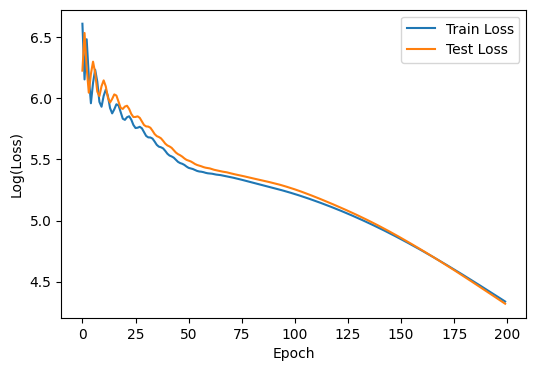

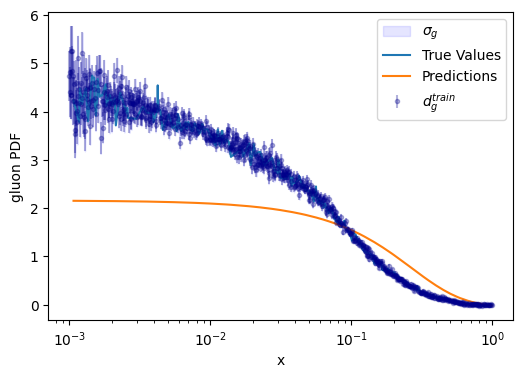

Epoch [400/800], Train Loss: 11.7437, Test Loss: 12.0631


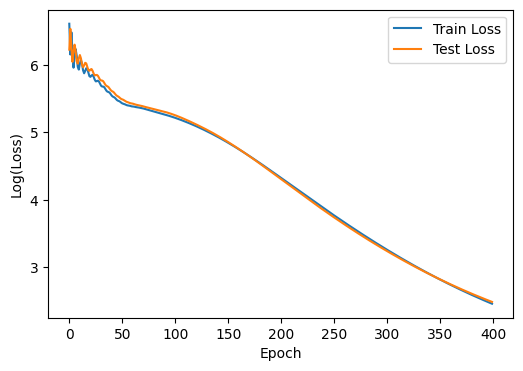

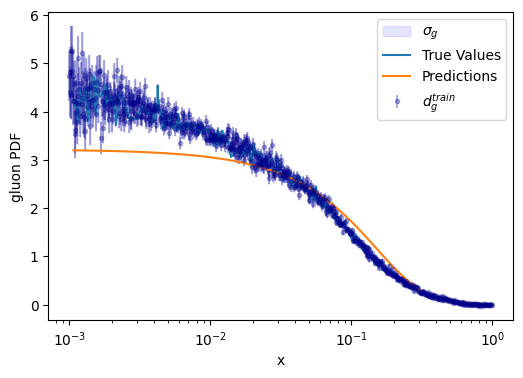

Epoch [600/800], Train Loss: 5.1471, Test Loss: 5.4711


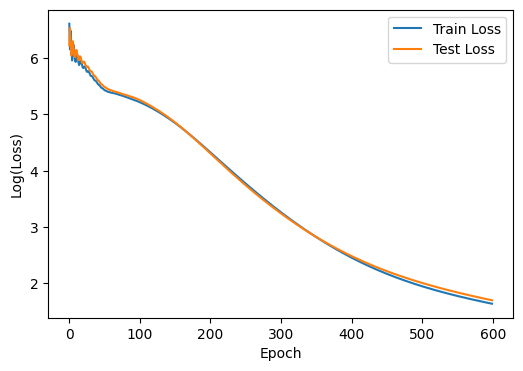

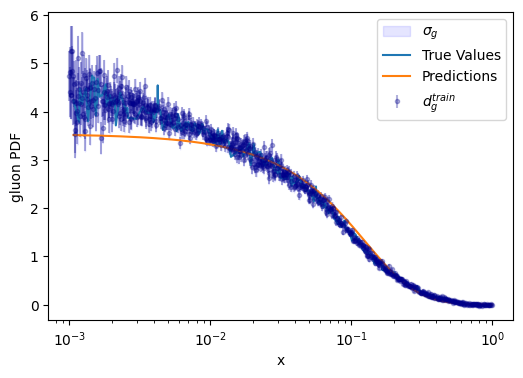

Epoch [800/800], Train Loss: 3.4380, Test Loss: 3.5504


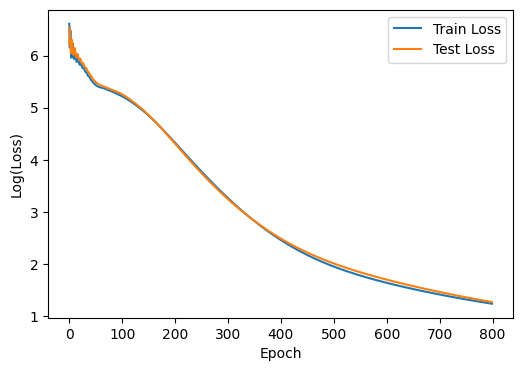

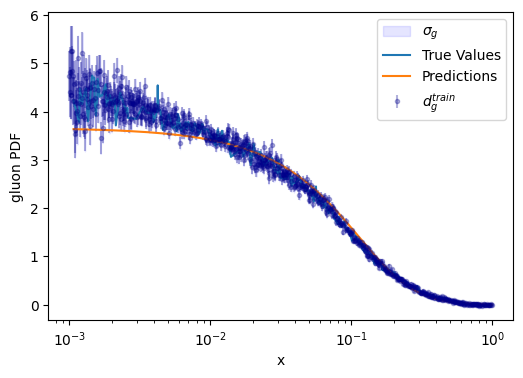

In [12]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

VERBOSITY=True #choose True to plot the NN every iteration

plt.figure(figsize=(15,10))

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data
#x_train = torch.tensor(df_train['x'].values.reshape(-1, 1)).float().to(device)
#y_train = torch.tensor(df_train['gluon_cv'].values.reshape(-1, 1)).float().to(device)
#dy_train = torch.tensor(df_train['gluon_sd'].values.reshape(-1, 1)).float().to(device)


# Prepare data
x_train = torch.tensor(df_train['x'].values.reshape(-1, 1)).float().to(device)
y_train = torch.tensor(df_train['gluon_cv'].values.reshape(-1, 1)).float().to(device)
dy_train = torch.tensor(df_train['gluon_sd'].values.reshape(-1, 1)).float().to(device)


train_dataset = TensorDataset(x_train, y_train, dy_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

x_test = torch.tensor(df_test['x'].values.reshape(-1, 1)).float().to(device)
y_test = torch.tensor(df_test['gluon_cv'].values.reshape(-1, 1)).float().to(device)
dy_test = torch.tensor(df_test['gluon_sd'].values.reshape(-1, 1)).float().to(device)

test_dataset = TensorDataset(x_test, y_test, dy_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize network
model = Torch_Model(n_features, n_neurons, n_outputs).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_step = make_train_step(model, criterion, optimizer)

train_losses = []
test_losses = []
for epoch in range(n_epochs):
    train_loss = 0
    for x_batch, y_batch, dy_batch in train_loader:
        loss = train_step(x_batch, y_batch, dy_batch)
        train_loss += loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    with torch.no_grad():
        test_loss = 0
        for x_batch, y_batch, dy_batch in test_loader:
            model.eval()
            y_pred = model(x_batch)
            loss = criterion(y_batch / dy_batch, y_pred / dy_batch)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

    plot_graphs(epoch, n_epochs, train_losses, test_losses, model, x_test, y_test, df_train, dy_train)


In [13]:
! pip install -q torchview
! pip install -q -U graphviz

In [14]:
from torchview import draw_graph
from torch import nn
import torch
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')

'svg'

## **Things To Try**



Try modifying (one at a time) the:
- Amount of **training epochs**.
#### Question 2a.1) How does the model perform on the test set with respect to the amount of training epochs?

- **Activation functions**: relu, sigmoid, tanh (go back to the construction of the NN above).
#### Question 2a.2) Which activation gives the smallest test chi-squared value for a fixed number of training epochs?

- **Architectures**: Increase the number of neurons in the hidden layer.
#### Question 2a.3) Do you notice any change in the flexibility of the neural network? Try adding another hidden layer. Do you get better model performance on the test set? Can you think of a reason why this would be the case?
- **Learning rates** of the optimizer.
#### Question 2a.4) How does the convergence speed change?

- **Optimizers**, e.g. `RMSprop` or `Adagrad`
#### Question 2a.5) Which optimizer performs the best given the same number of training epochs?

Tune the various options listed above.

#### Question 2a.6) What is the best test chi-squared that you obtain?

Improve the notebook in terms of its usage and readability. Document your improvements.

#### Question 2a.7) Is your improved notebook uses pytorch for all ingredients?

In [15]:
# install torchviz, we will need it later to explore the models
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=a2c5618547e53872def3ffffc5c470d66d991aa397cadaace10963473b0af83d
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [16]:


model_graph_2 = draw_graph(
    model, input_size=(1,),
    graph_name='RecursiveNet',
    roll=True
)

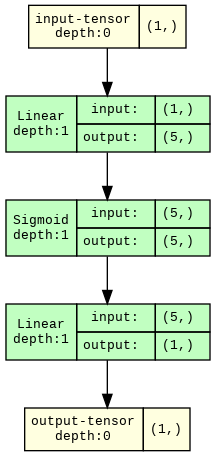

In [23]:
model_graph_2.visual_graph

https://saturncloud.io/blog/how-to-visualize-a-neural-network/#:~:text=There%20are%20several%20ways%20to%20visualize%20a%20neural%20network%2C%20including,and%20goals%20of%20the%20project.


https://saturncloud.io/blog/how-to-visualize-a-net-in-pytorch/#:~:text=Visualizing%20the%20Model,representation%20of%20the%20computation%20graph.


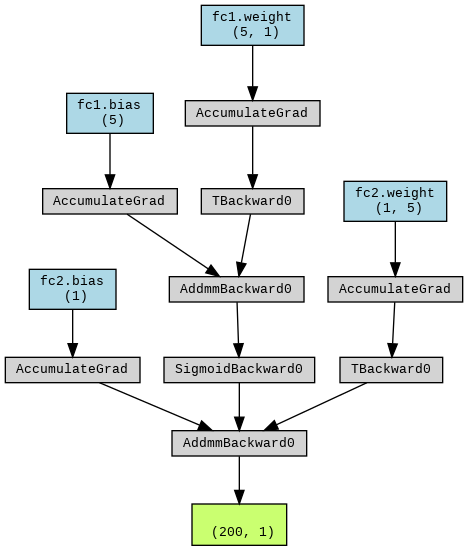

In [24]:
import torch
from torchviz import make_dot

x = x_test
y = model(x)
make_dot(y, params=dict(model.named_parameters()))